In [1]:
# 라이브러리
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
# 라이브러리
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import statsmodels.formula.api as smf

from imblearn.over_sampling import SMOTE 

In [3]:
# 평가함수

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)    # 오차행렬
    accuracy = accuracy_score(y_test , pred)      # 정확도
    precision = precision_score(y_test , pred)    # 정밀도
    recall = recall_score(y_test , pred)          # 재현율
    f1 = f1_score(y_test,pred)
                    
    print('오차 행렬')
    print(confusion)
    print('정확도: {:.4f}, 정밀도: {:.4f}, 재현율: {:.4f}, F1: {:.4f}'.format(accuracy, precision, recall, f1))

### 초기설정 : Train 7 : test 3

In [94]:
data = pd.read_csv('data.csv')

In [95]:
data['TAG'] = data['TAG'].apply(lambda x : 0 if x =='OK' else 1 )

X, y = data[['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP']], data['TAG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [96]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((584640, 4), (250560, 4), (584640,), (250560,))

### Train 데이터 확인

In [9]:
train_visualize = pd.concat([X_train, y_train], axis=1)

In [10]:
train_visualize['TAG'].value_counts(normalize=True)

0    0.787994
1    0.212006
Name: TAG, dtype: float64

<AxesSubplot:xlabel='MOTORSPEED', ylabel='MELT_WEIGHT'>

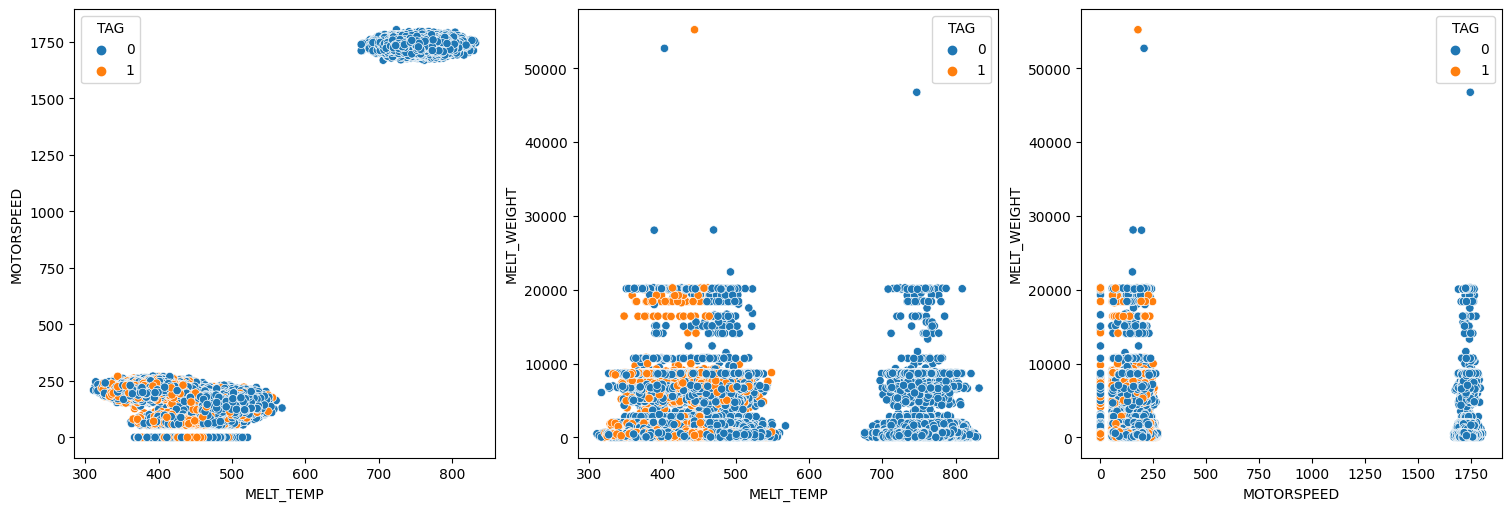

In [12]:
fig, axs = plt.subplots(figsize=(15,5), nrows=1, ncols=3, constrained_layout=True)

sns.scatterplot(data=train_visualize, x ='MELT_TEMP', y='MOTORSPEED', hue='TAG', ax = axs[0])
sns.scatterplot(data=train_visualize, x ='MELT_TEMP', y='MELT_WEIGHT', hue='TAG', ax = axs[1])
sns.scatterplot(data=train_visualize, x ='MOTORSPEED', y='MELT_WEIGHT', hue='TAG', ax = axs[2])

### 위험군 분류 : 경계수준, 위험수준

In [14]:
# 경계수준
data_visualize[(data_visualize['MELT_WEIGHT'] < 21000) & (data_visualize['MELT_TEMP'] < 600)]['TAG'].value_counts(normalize=True)

0    0.735148
1    0.264852
Name: TAG, dtype: float64

In [15]:
# 위험수준
data_visualize[(data_visualize['MELT_WEIGHT'] > 15000) & (data_visualize['MELT_WEIGHT'] < 20000) & (data_visualize['MELT_TEMP'] < 480)]['TAG'].value_counts(normalize=True)

1    0.504132
0    0.495868
Name: TAG, dtype: float64

### 위험군분류 파생변수 만들기

In [97]:
################# 이 함수 적용하면 됩니다 #################

def make_df_warning_area(df) :
    
    df_new = df.copy()
    
    # 경계수준 인덱스
    w1_idx_list = df_new[(df_new['MELT_WEIGHT'] < 21000) & (df_new['MELT_TEMP'] < 600)].index  
    
    # 위험수준 인덱스
    w2_idx_list = df_new[(df_new['MELT_WEIGHT'] > 15000) & (df_new['MELT_WEIGHT'] < 20000) & (df_new['MELT_TEMP'] < 480)].index
    
    # 데이터프레임['warning_area'] 초기화
    df_new['warning_area'] = 0
    
    # 위험군 값 입력
    df_new.loc[w1_idx_list, 'warning_area'] = 0.5
    df_new.loc[w2_idx_list, 'warning_area'] = 2
    
    
    return df_new

In [98]:
X_train_new = make_df_warning_area(X_train)

In [99]:
X_train_new['warning_area'].value_counts()

0.5    467861
0.0    116658
2.0       121
Name: warning_area, dtype: int64

In [100]:
X_train_new.head()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,warning_area
523489,480,102,628,3.19,0.5
321406,375,186,759,3.19,0.5
514891,472,74,198,3.19,0.5
203459,456,97,417,3.20,0.5
153104,753,1736,309,3.22,0.0


In [101]:
X_test_new = make_df_warning_area(X_test)

In [102]:
X_test_new['warning_area'].value_counts()

0.5    200119
0.0     50388
2.0        53
Name: warning_area, dtype: int64

In [103]:
X_test_new.head()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,warning_area
17986,358,197,134,3.19,0.5
417988,440,59,205,3.19,0.5
356209,449,145,403,3.20,0.5
20481,458,92,526,3.19,0.5
518863,379,191,527,3.18,0.5


### 모델링(파생변수 추가 전후 비교)

In [111]:
# RF : f1 기준 > 아주 소폭 증가

rf = RandomForestClassifier()
rf_new = RandomForestClassifier()

rf.fit(X_train, y_train)
rf_new.fit(X_train_new, y_train)

RandomForestClassifier()

In [112]:
pred = rf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[177525  19915]
 [ 37915  15205]]
정확도: 0.7692, 정밀도: 0.4329, 재현율: 0.2862, F1: 0.3446


In [113]:
pred = rf_new.predict(X_test_new)
get_clf_eval(y_test, pred)

오차 행렬
[[177204  20236]
 [ 37710  15410]]
정확도: 0.7687, 정밀도: 0.4323, 재현율: 0.2901, F1: 0.3472


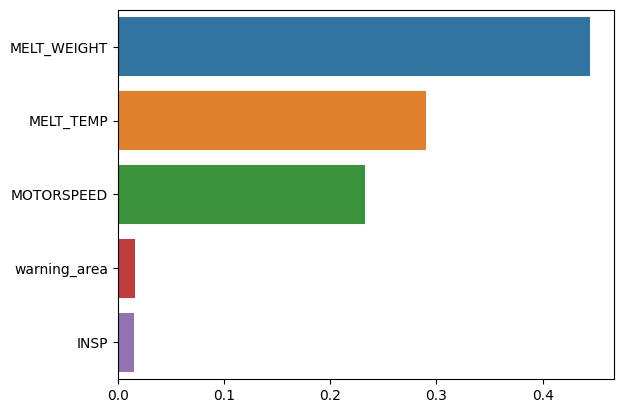

In [57]:
feature_series = pd.Series(rf_new.feature_importances_, index=X_train_new.columns).sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)
plt.show()

In [ ]:
# 로지스틱 : f1 기준 > 아주 소폭 증가

In [104]:
# 정규화 수행 min_max

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_new_scaled = scaler.fit_transform(X_train_new)
X_test_new_scaled  = scaler.transform(X_test_new)

In [105]:
lr_clf = LogisticRegression() 
lr_clf_new = LogisticRegression() 

lr_clf.fit(X_train_scaled , y_train)
lr_clf_new.fit(X_train_new_scaled , y_train)

LogisticRegression()

In [106]:
pred = lr_clf.predict(X_test_scaled)
get_clf_eval(y_test, pred)

오차 행렬
[[193922   3518]
 [ 50837   2283]]
정확도: 0.7831, 정밀도: 0.3936, 재현율: 0.0430, F1: 0.0775


In [107]:
pred = lr_clf_new.predict(X_test_new_scaled)
get_clf_eval(y_test, pred)

오차 행렬
[[193926   3514]
 [ 50826   2294]]
정확도: 0.7831, 정밀도: 0.3950, 재현율: 0.0432, F1: 0.0779


In [108]:
temp1 = pd.DataFrame(X_train_new_scaled, columns=X_train_new.columns)
temp2 = pd.DataFrame(y_train, columns=['TAG']).reset_index(drop=True)

df_train = pd.concat([temp1, temp2], axis=1)

In [109]:
df_train

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,warning_area,TAG
0,0.324376,0.056541,0.011366,0.333333,0.25,0
1,0.122841,0.103104,0.013737,0.333333,0.25,1
2,0.309021,0.041020,0.003584,0.333333,0.25,0
3,0.278311,0.053769,0.007547,0.500000,0.25,0
4,0.848369,0.962306,0.005593,0.833333,0.00,0
...,...,...,...,...,...,...
584635,0.138196,0.107539,0.004633,0.166667,0.25,0
584636,0.332054,0.038803,0.009954,0.166667,0.25,0
584637,0.385797,0.097007,0.006516,0.500000,0.25,0
584638,0.128599,0.110310,0.001014,0.166667,0.25,0


In [110]:
model = smf.ols(formula = 'TAG ~ MELT_TEMP + MOTORSPEED + MELT_WEIGHT + INSP + warning_area', data=df_train)
result = model.fit()
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    TAG   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.478e+04
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        21:48:28   Log-Likelihood:            -2.7169e+05
No. Observations:              584640   AIC:                         5.434e+05
Df Residuals:                  584634   BIC:                         5.435e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.2913      0.011    113.547      0.000       1.269       1.314
MELT_TEMP       -1.1114      0.008   -148.087      0.000      -1.126      -1.097
MOTORSPEED      -0.4121      0.011    -38.575      0.000      -0.433      -0.391
MELT_WEIGHT      0.4789      0.023     20.754      0.000       0.434       0.524
INSP             0.0502      0.006      7.733      0.000       0.037       0.063
warning_area    -2.8844      0.040    -72.936      0.000      -2.962      -2.807
==============================================================================
Omnibus:                    81812.997   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           122319.718
Skew:                           1.120   Prob(JB):                         0.00
Kurtosis:                       2.929   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### SMOTE : 재현율 향상 초점

In [121]:
X_train_new.columns[:-1]

Index(['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP'], dtype='object')

In [154]:
def make_smote(df_X, df_y) :
    
    ########### 위험군 변수가 추가된 df이면 위험군 변수를 제거하고 SMOTE 후 def : make_df_warning_area 호출 ###########
    
    smote = SMOTE(random_state=0)

    
    df_X_over = df_X.copy()
    df_y_over = df_y.copy()
    
    if df_X_over.shape[1] == 4 :
    
    
        df_X_over, df_y_over = smote.fit_resample(df_X_over, df_y_over)
        
        
    else : 
        print('위험군 변수를 제외했다가 다시 생성함')
        
        temp = df_X_over[df_X_over.columns[:-1]]
        
        temp, df_y_over = smote.fit_resample(temp, df_y_over)
        
        df_X_over = make_df_warning_area(temp)

        
    return df_X_over, df_y_over

In [151]:
####### 예비용

X_train_over = X_train_over.drop(columns='warning_area')

w1_idx_list = X_train_over[(X_train_over['MELT_WEIGHT'] < 21000) & (X_train_over['MELT_TEMP'] < 600)].index
w2_idx_list = X_train_over[(X_train_over['MELT_WEIGHT'] > 15000) & (X_train_over['MELT_WEIGHT'] < 20000) & (data_visualize['MELT_TEMP'] < 480)].index

X_train_over['warning_area'] = 0
X_train_over.loc[w1_idx_list, 'warning_area'] = 1
X_train_over.loc[w2_idx_list, 'warning_area'] = 2

In [172]:
X_train_over, y_train_over = make_smote(X_train, y_train)

In [173]:
X_train_over.shape, y_train_over.shape

((921386, 4), (921386,))

In [174]:
X_train_new_over, y_train_new_over = make_smote(X_train_new, y_train)

위험군 변수를 제외했다가 다시 생성함


In [175]:
X_train_new_over.shape, y_train_over.shape 

((921386, 5), (921386,))

In [180]:
X_train_new_over['warning_area'].value_counts()

0.5    804448
0.0    116659
2.0       279
Name: warning_area, dtype: int64

### 모델링(SMOTE 후)

In [181]:
# RF : f1 기준 > 아주 소폭 증가

rf = RandomForestClassifier()
rf_new = RandomForestClassifier()

rf.fit(X_train_over, y_train_over)
rf_new.fit(X_train_new_over, y_train_new_over)

RandomForestClassifier()

In [182]:
pred = rf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[159045  38395]
 [ 27877  25243]]
정확도: 0.7355, 정밀도: 0.3967, 재현율: 0.4752, F1: 0.4324


In [183]:
pred = rf_new.predict(X_test_new)
get_clf_eval(y_test, pred)

오차 행렬
[[158516  38924]
 [ 27629  25491]]
정확도: 0.7344, 정밀도: 0.3957, 재현율: 0.4799, F1: 0.4338


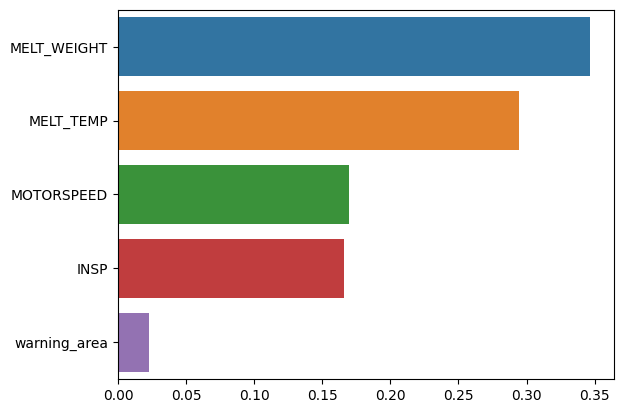

In [184]:
feature_series = pd.Series(rf_new.feature_importances_, index=X_train_new.columns).sort_values(ascending=False)
sns.barplot(x= feature_series, y=feature_series.index)
plt.show()

In [188]:
X_train_over.shape, X_train_new_over.shape, X_test.shape, X_test_new.shape

((921386, 4), (921386, 5), (250560, 4), (250560, 5))

In [189]:
# 정규화 수행 min_max

scaler = MinMaxScaler()

X_train_over_scaled = scaler.fit_transform(X_train_over)
X_test_scaled  = scaler.transform(X_test)

X_train_new_over_scaled = scaler.fit_transform(X_train_new_over)
X_test_new_scaled  = scaler.transform(X_test_new)

In [192]:
lr_clf = LogisticRegression() 
lr_clf_new = LogisticRegression() 

lr_clf.fit(X_train_over_scaled , y_train_over)
lr_clf_new.fit(X_train_new_over_scaled , y_train_over)

LogisticRegression()

In [193]:
pred = lr_clf.predict(X_test_scaled)
get_clf_eval(y_test, pred)

오차 행렬
[[128775  68665]
 [ 11308  41812]]
정확도: 0.6808, 정밀도: 0.3785, 재현율: 0.7871, F1: 0.5112


### 최후모델 : 정확도 0.6809, 재현율: 0.7872, 

In [194]:
pred = lr_clf_new.predict(X_test_new_scaled)
get_clf_eval(y_test, pred)

오차 행렬
[[128783  68657]
 [ 11305  41815]]
정확도: 0.6809, 정밀도: 0.3785, 재현율: 0.7872, F1: 0.5112


In [196]:
pred_2 = np.where(lr_clf_new.predict_proba(X_test_new_scaled)[:, 1] >= 0.57, 1, 0)

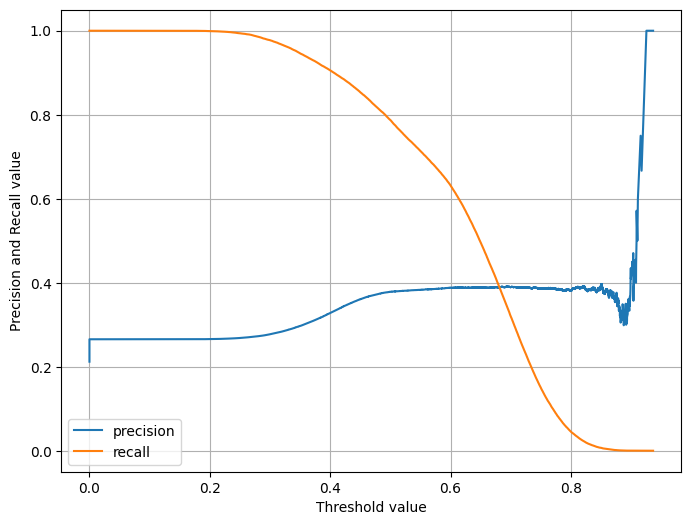

In [198]:
from sklearn.metrics import precision_recall_curve


def precision_recall_curve_plot(y_test , pred_proba_positive):
    # precision_recall_curve( ) - 결정임계값에 따른 정밀도, 재현율 배열 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_positive)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 lineplot
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    sns.lineplot(x=thresholds, y=precisions[0:threshold_boundary], label='precision')
    sns.lineplot(x=thresholds, y=recalls[0:threshold_boundary], label='recall')
 
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf_new.predict_proba(X_test_new_scaled)[:, 1] ) # 함수 적용


In [203]:
temp1 = pd.DataFrame(X_train_new_over_scaled, columns=X_train_new.columns)
temp2 = pd.DataFrame(y_train_over, columns=['TAG'])

df_train = pd.concat([temp1, temp2], axis=1)

In [204]:
df_train.columns

Index(['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'warning_area',
       'TAG'],
      dtype='object')

In [205]:
model = smf.ols(formula = 'TAG ~ MELT_TEMP + MOTORSPEED + MELT_WEIGHT + INSP + warning_area', data=df_train)
result = model.fit()
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    TAG   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                 4.763e+04
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:30:01   Log-Likelihood:            -5.6282e+05
No. Observations:              921386   AIC:                         1.126e+06
Df Residuals:                  921380   BIC:                         1.126e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.7430      0.009    191.227      0.000       1.725       1.761
MELT_TEMP       -1.5692      0.007   -223.786      0.000      -1.583      -1.555
MOTORSPEED      -0.5484      0.009    -64.472      0.000      -0.565      -0.532
MELT_WEIGHT      0.7310      0.021     34.105      0.000       0.689       0.773
INSP             0.1239      0.006     19.438      0.000       0.111       0.136
warning_area    -3.1222      0.032    -99.080      0.000      -3.184      -3.060
==============================================================================
Omnibus:                  2832138.034   Durbin-Watson:                   1.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            77148.993
Skew:                          -0.293   Prob(JB):                         0.00
Kurtosis:                       1.710   Cond. No.                         85.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""